# Titanic Problem
## Hypothesis
Certain people were more likely to survive than others, based on some of their 'characteristics'

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

current_path = os.getcwd()
seed_val = 2022

In [2]:
train_dataset = pd.read_csv(os.path.join(current_path, 'Data', 'train.csv'))
test_dataset = pd.read_csv(os.path.join(current_path, 'Data', 'test.csv'))

### Headings
sibsp = # of siblings / spouses aboard the Titanic

parch =  # of parents / children aboard the titanic

embarked = port of embarkation

In [3]:
train_dataset.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
train_dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


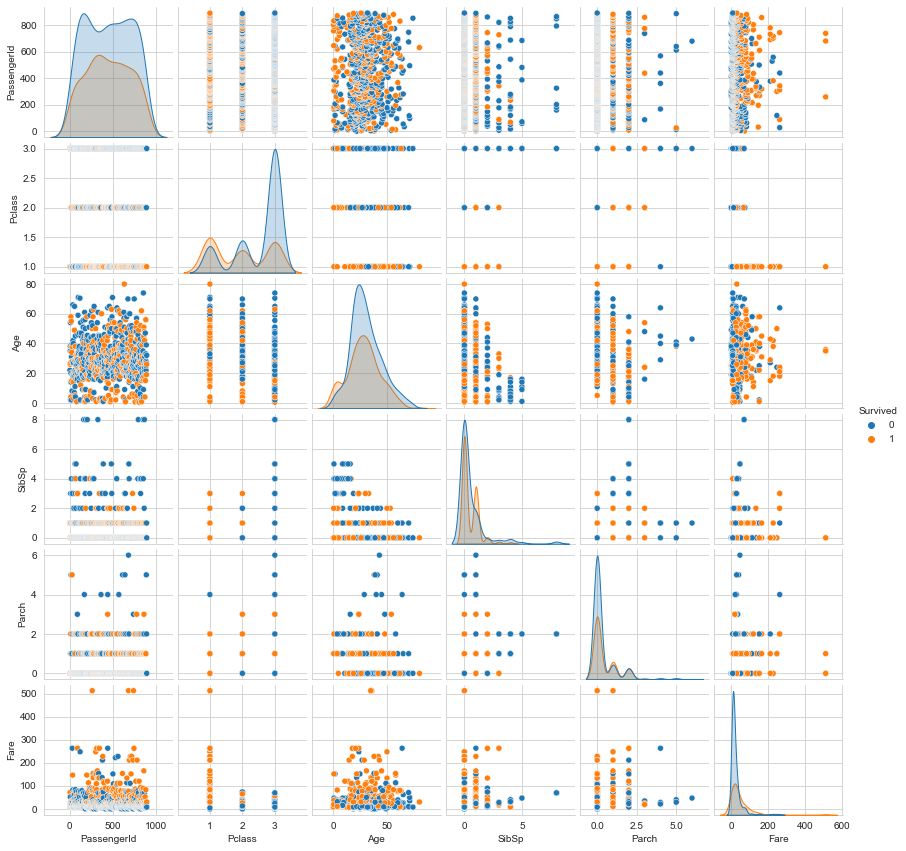

In [5]:
sns.set_style("whitegrid");
sns.pairplot(train_dataset, hue='Survived', height=2);
plt.show()

From the pairplot, it seems like:
- Has relationship: Pclass, Age, SibSp and Parch + Fare which has a strong relationship with Pclass
- No relationship: PassengerId 

In [5]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_dataset.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [7]:
train_dataset.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Data inconsistencies
- Dataset legnth = (891, 12)
- Name, PassengerId & Ticket can be __dropped__ because they seem to be unique
    - The ticket and cabin features may be strongly associated with fare feature
- NANs: Age (177) & Cabin (687)
    - Cabin should be __dropped__ because it has too many NAN value (>> 50%)
    - Age NANs can't be be 'presumed', although age may improve accuracy of the data
        - Age should be __dropped__ for now
- Sex needs to be encoded to (0 = Male, 1 = Female)
- Encoding SibSp, Parch and Fare may improve performance 
- __Drop__ the 2 Embarked = Nan rows

In [8]:
train_dataset['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [9]:
names = train_dataset['Name']
train_dataset_copy = train_dataset.copy().drop(columns=['PassengerId', 'Name', 'Age', 'Ticket', 'Cabin'])
train_dataset_copy.tail()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
886,0,2,male,0,0,13.00,S
887,1,1,female,0,0,30.00,S
888,0,3,female,1,2,23.45,S
889,1,1,male,0,0,30.00,C
890,0,3,male,0,0,7.75,Q


In [10]:
print(np.shape(train_dataset_copy))
train_dataset_copy = train_dataset_copy.dropna()
print(np.shape(train_dataset_copy))

(891, 7)
(889, 7)


In [11]:
train_LABELS = train_dataset_copy['Survived']
train_FEATURES = train_dataset_copy.drop(columns='Survived') 

In [12]:
train_FEATURES.tail()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
886,2,male,0,0,13.00,S
887,1,female,0,0,30.00,S
888,3,female,1,2,23.45,S
889,1,male,0,0,30.00,C
890,3,male,0,0,7.75,Q


- Function to encode from non-numeric data to numeric (presuming they are all of one type per column)
- Function to scale the data per column

In [13]:
def encode_non_numeric_data(df):
    df = df.copy()
    columns = df.columns.values
    for col in columns:
        if df[col].dtype != int and df[col].dtype != float:
            unique_vals = df[col].unique()
            reassign_dict = {unique_vals[i]: i for i in range(0, len(unique_vals), 1)}
            df = df.replace({col: reassign_dict})
    return df


def MinMaxScale_data(features):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(features)
    return scaler.transform(features)

In [14]:
train_FEATURES = encode_non_numeric_data(train_FEATURES)
train_FEATURES.tail()


,Pclass,Sex,SibSp,Parch,Fare,Embarked
886,2,0,1,0,13.00,0
887,1,1,1,0,30.00,0
888,0,1,0,2,23.45,0
889,1,0,1,0,30.00,1
890,0,0,1,0,7.75,2


In [15]:
for col in ['Pclass', 'SibSp', 'Parch', 'Fare']:
    train_FEATURES[col] = MinMaxScale_data(np.array(train_FEATURES[col]).reshape(-1,1))

train_FEATURES.tail()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
886,1.0,0,0.166667,0.000000,0.025374,0
887,0.5,1,0.166667,0.000000,0.058556,0
888,0.0,1,0.000000,0.333333,0.045771,0
889,0.5,0,0.166667,0.000000,0.058556,1
890,0.0,0,0.166667,0.000000,0.015127,2


In [16]:
train_LABELS.tail()

886    0
887    1
888    0
889    1
890    0
Name: Survived, dtype: int64

In [17]:
def get_errors(labels, predictions):
    errors = np.array([0])
    errors = np.append(errors, np.array(predictions-labels))
    error = np.mean(errors)
    delta_avg = [0]
    for i in range(0, len(errors)):
        delta_avg.append(np.mean(errors[0:i]))
    return error, delta_avg

In [133]:
pca = PCA(2)
X_pca = pca.fit_transform(train_FEATURES.copy())

### PCA + K-Means
estimator 1

In [207]:
n = 2

KMeans_base_estimator = KMeans(n_clusters=2, 
                               init='k-means++', 
                               n_init=10, max_iter=1000, 
                               tol=0.00001, 
                               verbose=0, 
                               random_state=seed_val, 
                               copy_x=True, 
                               algorithm='auto')

In [208]:
predicted = KMeans_base_estimator.fit_predict(X)

In [217]:
errors, delta_avg = get_errors(train_LABELS, predicted)
print(f"Average error: {np.mean(errors)}")

Average error: -0.10686164229471316


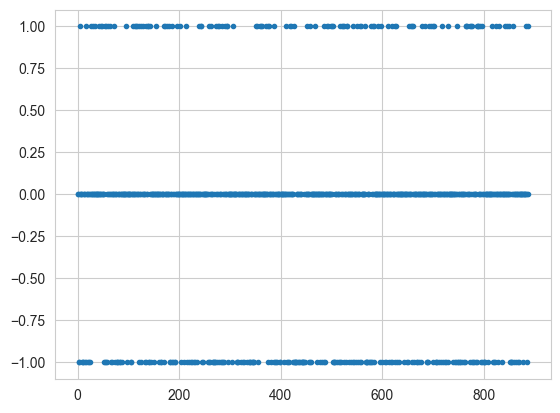

In [218]:
plt.scatter(np.arange(0, len(predicted)), (errors), marker='.')

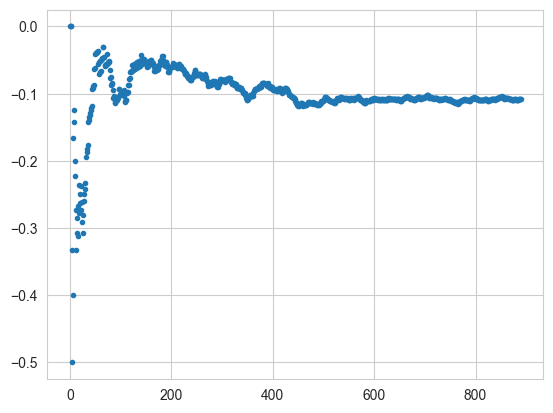

In [219]:
plt.scatter(np.arange(0, len(delta_avg)), (delta_avg), marker='.')

# MLP Regressor

In [18]:
from sklearn.neural_network import MLPRegressor

In [19]:
MLPR_base_estimator = MLPRegressor(hidden_layer_sizes=(100,20),
                                   activation='relu',
                                   solver='adam')

In [25]:
X_pca = train_FEATURES.copy()
MLPR_base_estimator.fit(X, train_LABELS)

MLPRegressor(hidden_layer_sizes=(100, 20))

In [26]:
MLPR_predictions = MLPR_base_estimator.predict(X)

In [27]:
MLPR_error, MLPReg_delta_avg = get_errors(train_LABELS, MLPR_predictions)

c:\Users\niravs\Documents\Other\KaggleComp-TitanicMachineLearningFromDisaster\.Kaggle\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\niravs\Documents\Other\KaggleComp-TitanicMachineLearningFromDisaster\.Kaggle\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average error: 0.0010907755823242442


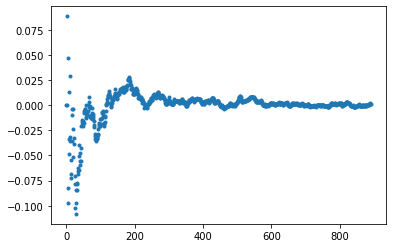

In [28]:
print(f"Average error: {np.mean(MLPR_error)}")
plt.scatter(np.arange(0, len(MLPReg_delta_avg)), MLPReg_delta_avg, marker='.')

# MLP Classifier

In [86]:
from sklearn.neural_network import MLPClassifier

In [87]:
MLPC_base_estimator = MLPClassifier(hidden_layer_sizes=(100,20),
                                    activation='relu',
                                    solver='adam')

In [88]:
MLPC_base_estimator.fit(X_pca, train_LABELS)

c:\Users\niravs\Documents\Other\KaggleComp-TitanicMachineLearningFromDisaster\.Kaggle\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 20))

In [89]:
MLPC_predictions = MLPC_base_estimator.predict(X_pca)

In [90]:
MLPC_error, MLPC_delta_avg = get_errors(train_LABELS, MLPC_predictions)

c:\Users\niravs\Documents\Other\KaggleComp-TitanicMachineLearningFromDisaster\.Kaggle\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\niravs\Documents\Other\KaggleComp-TitanicMachineLearningFromDisaster\.Kaggle\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average error: -0.10112359550561797


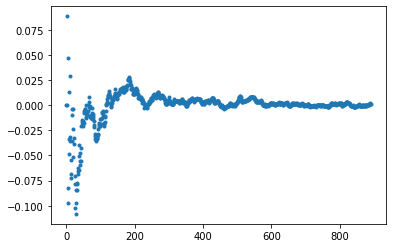

In [91]:
print(f"Average error: {np.mean(MLPC_error)}")
plt.scatter(np.arange(0, len(MLPReg_delta_avg)), MLPReg_delta_avg, marker='.')

# Gradient boosted Classifier

In [97]:
from sklearn.ensemble import GradientBoostingClassifier

In [134]:
GBClassifier_base_estimator = GradientBoostingClassifier(learning_rate=0.2,
                                    n_estimators=100)

In [135]:
GBClassifier_base_estimator.fit(X_pca, train_LABELS)

GradientBoostingClassifier(learning_rate=0.2)

In [136]:
# GBClassifier_predictions = GBClassifier_base_estimator.predict(X_pca)
GBClassifier_predictions = GBClassifier_base_estimator.predict(X)

Average error: -0.06741573033707865


c:\Users\niravs\Documents\Other\KaggleComp-TitanicMachineLearningFromDisaster\.Kaggle\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\niravs\Documents\Other\KaggleComp-TitanicMachineLearningFromDisaster\.Kaggle\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


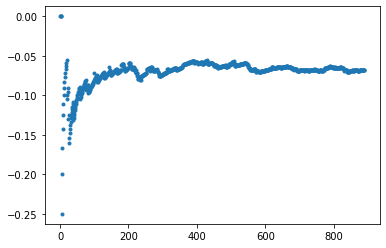

In [137]:
GBClassifier_error, GBClassifier_delta_avg = get_errors(train_LABELS, GBClassifier_predictions)
print(f"Average error: {np.mean(GBClassifier_error)}")
plt.scatter(np.arange(0, len(GBClassifier_delta_avg)), GBClassifier_delta_avg, marker='.')

# Test Data

In [122]:
test_dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [123]:
test_dataset_copy = test_dataset.copy().drop(columns=['PassengerId', 'Name', 'Age', 'Ticket', 'Cabin'])
test_dataset_copy.tail()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
413,3,male,0,0,8.0500,S
414,1,female,0,0,108.9000,C
415,3,male,0,0,7.2500,S
416,3,male,0,0,8.0500,S
417,3,male,1,1,22.3583,C


In [124]:
test_FEATURES = encode_non_numeric_data(test_dataset_copy)
for col in ['Pclass', 'SibSp', 'Parch', 'Fare']:
    test_FEATURES[col] = MinMaxScale_data(np.array(test_FEATURES[col]).reshape(-1,1))

test_FEATURES.tail()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
413,0.0,0,0.000000,0.000000,0.015713,1
414,1.0,1,0.000000,0.000000,0.212559,2
415,0.0,0,0.000000,0.000000,0.014151,1
416,0.0,0,0.000000,0.000000,0.015713,1
417,0.0,0,0.166667,0.142857,0.043640,2


In [125]:
test_FEATURES.isna().sum()

Pclass      0
Sex         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64

In [126]:
test_FEATURES['Fare'].fillna(train_FEATURES['Fare'].mean(), inplace=True)

In [127]:
test_FEATURES.isna().sum()

Pclass      0
Sex         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Test features has a row with a 'na' value in fare. I could try averaging them and placing the average for the fare amount.

In [129]:
X_test_pca = pca.fit_transform(test_FEATURES.copy())

In [132]:
X = test_FEATURES.copy()
GBClassifier_test_predictions = GBClassifier_base_estimator.predict(X)
# MLPR_error, MLPReg_delta_avg = get_errors(train_LABELS, MLPR_predictions)
# print(f"Average error: {np.mean(MLPR_error)}")
# plt.scatter(np.arange(0, len(MLPReg_delta_avg)), MLPReg_delta_avg, marker='.')

In [93]:
output = pd.DataFrame(columns=['PassengerId', 'Survived'])


In [94]:
output = pd.DataFrame()
output['PassengerId'] = test_dataset['PassengerId']
output['Survived'] = MLPR_predictions

In [95]:
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [96]:
output.to_csv(os.path.join('Data', 'submission.csv'))